# Email Classification

We will use fast.ai to build an email ham/spam classifier.

# Load data

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/himalayahall/DATA607/main/Project4/EMAILSpamCollectionFull.csv')

In [2]:
df.head()

,id,from,subject,category,text
0,1,robert elz <kre@munnari.oz.au>,re: new sequences window,ham,"Date: Wed, 21 Aug 2002 10:54:46 -0..."
1,2,steve burt <steve_burt@cursor-system.com>,[zzzzteana] re: alexander,ham,"Martin A posted:Tassos Papadopoulos, the Gree..."
2,3,"""tim chapman"" <timc@2ubh.com>",[zzzzteana] moscow bomber,ham,Man Threatens Explosion In Moscow Thursday Au...
3,4,monty solomon <monty@roscom.com>,[irr] klez: the virus that won't die,ham,Klez: The Virus That Won't Die Already the mo...
4,5,tony nugent <tony@linuxworks.com.au>,re: insert signature,ham,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wro..."


In [3]:
df.describe(include='object')

,from,subject,category,text
count,7933,7903,9350,7953
unique,2388,3491,2,4618
top,boingboing <rssfeeds@example.com>,[spambayes] test sets?,ham,
freq,114,58,5553,84


# Cleanup Data

Drop NAs.

In [4]:
df1 = df.dropna()
df1.isna().sum()

id          0
from        0
subject     0
category    0
text        0
dtype: int64

Remove **id** and **email_src** columns.

In [5]:
df1 = df1[['from', 'subject', 'text', 'category']]
df1.head()

,from,subject,text,category
0,robert elz <kre@munnari.oz.au>,re: new sequences window,"Date: Wed, 21 Aug 2002 10:54:46 -0...",ham
1,steve burt <steve_burt@cursor-system.com>,[zzzzteana] re: alexander,"Martin A posted:Tassos Papadopoulos, the Gree...",ham
2,"""tim chapman"" <timc@2ubh.com>",[zzzzteana] moscow bomber,Man Threatens Explosion In Moscow Thursday Au...,ham
3,monty solomon <monty@roscom.com>,[irr] klez: the virus that won't die,Klez: The Virus That Won't Die Already the mo...,ham
4,tony nugent <tony@linuxworks.com.au>,re: insert signature,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wro...",ham


Strip HTML tags.

In [6]:
df1['subject'] = df1['subject'].replace('<[^<>]*>', " ", regex=True)
df1['text'] = df1['text'].replace('<[^<>]*>', " ", regex=True)
df1.head()

,from,subject,text,category
0,robert elz <kre@munnari.oz.au>,re: new sequences window,"Date: Wed, 21 Aug 2002 10:54:46 -0...",ham
1,steve burt <steve_burt@cursor-system.com>,[zzzzteana] re: alexander,"Martin A posted:Tassos Papadopoulos, the Gree...",ham
2,"""tim chapman"" <timc@2ubh.com>",[zzzzteana] moscow bomber,Man Threatens Explosion In Moscow Thursday Au...,ham
3,monty solomon <monty@roscom.com>,[irr] klez: the virus that won't die,Klez: The Virus That Won't Die Already the mo...,ham
4,tony nugent <tony@linuxworks.com.au>,re: insert signature,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wro...",ham


Look at data summary.

In [7]:
df1.describe(include='object')

,from,subject,text,category
count,7902,7902,7902,7902
unique,2366,3490,4553,2
top,boingboing <rssfeeds@example.com>,[spambayes] test sets?,,ham
freq,114,58,48,5549


## Compute NULL model (baseline) accuracy

Compute baseline accuracy: any model worth considering must have greater accuracy (at a minimum) than null model. 

This data set is unbalanced (more ham instances than spams), null model has 70% accuracy.

In [8]:
cat_size = df1.groupby('category').size()
print(cat_size)

ham_prop = cat_size[0] / (cat_size[0] + cat_size[1])
print('Baseline (null model) accuracy: ' , ham_prop)

category
ham     5549
spam    2353
dtype: int64
Baseline (null model) accuracy:  0.70222728423184


## Prepare DataBlock

In [9]:
from fastai.data.all import *
from fastai.text.all import *

Create data loaders for classification, build **DataBlock** using **TextBlock** and **CategoryBlock**. Set aside 20% data using **TrainTestSplitter** for model testing.

In [10]:
dls_cls = DataBlock(
            blocks=(
                TextBlock.from_df(text_cols=('subject', 'text'), 
                        is_lm=False),
                CategoryBlock),
            get_x=ColReader('text'), 
            get_y=ColReader('category'),
            splitter=TrainTestSplitter(test_size=0.2,stratify=df1.category)
        ).dataloaders(df1)

In [11]:
dls_cls.show_batch(max_n = 5)

,text,category
0,"xxbos xxfld 1 = ? iso-2022 - xxunk xxfld 2 xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ xxrep 3 0 2_01c228ca.593b5280content - type : text / plain ; \t xxunk - xxunk - transfer - encoding : xxunk < xxunk xxrep 3 $ xxunk ! # xxunk ! # xxunk % / % xxunk , xxunk ! $ xxunk % / $ xxunk xxrep 3 $ xxunk , xxunk ! # xxunk : xxunk $ xxunk # ! xxunk xxrep 3 $ xxup xxunk / $ @$5$$ ! # ! xxunk / ! xxunk > xxunk $ / $ * 4j xxrep 5 $ ? $ 7$^$9 ! # xxunk xxrep 38 - + xxunk \ xxunk # % "" xxunk \ % xxunk # % xxunk ! e = xxunk xxunk -",ham
1,"xxbos xxfld 1 re : sed / s / united states / roman empire / g xxfld 2 "" free trade and free markets have proven their ability to lift xxunk out of xxunk not a socio - political / history buff - does anybody have some xxunk ? xxrep 5 - xxmaj original xxmaj message xxrep 5 - xxmaj from : "" rohit xxmaj khare "" xxmaj to : xxmaj sent : xxmaj friday , xxmaj september 20 , 2002 xxunk pmsubject : sed / s / xxmaj united xxmaj states / xxmaj roman xxmaj empire / g > > a world where some live in comfort and plenty , while half of the human > > race lives on less than $ 2 a day , is neither just nor stable . > > xxmaj absolutely correct . xxmaj perhaps the most fundamental thing to realize about >",ham
2,"xxbos xxfld 1 sed / s / united states / roman empire / g xxfld 2 > a world where some live in comfort and plenty , while half of the human > race lives on less than $ 2 a day , is neither just nor xxunk correct . xxmaj perhaps the most fundamental thing to realize about life on xxmaj earth xxunk following is a fascinating document of official xxmaj government policy that bears close reading . xxmaj it is the aspirations of a wonderful nation in an imperfect world . > xxmaj the war on terrorism is not a clash of civilizations . xxmaj it does , > however , reveal the clash inside a civilization , a battle for the > future of the xxmaj muslim world . xxmaj this is a struggle of ideas and this is an > area where xxmaj america must xxunk",ham
3,"xxbos xxfld 1 sed / s / united states / roman empire / g xxfld 2 > a world where some live in comfort and plenty , while half of the human > race lives on less than $ 2 a day , is neither just nor xxunk correct . xxmaj perhaps the most fundamental thing to realize about life on xxmaj earth xxunk following is a fascinating document of official xxmaj government policy that bears close reading . xxmaj it is the aspirations of a wonderful nation in an imperfect world . > xxmaj the war on terrorism is not a clash of civilizations . xxmaj it does , > however , reveal the clash inside a civilization , a battle for the > future of the xxmaj muslim world . xxmaj this is a struggle of ideas and this is an > area where xxmaj america must xxunk",ham
4,xxbos xxfld 1 = ? xxunk = f2 = d4 = xxunk xxfld 2 xxmaj this is a multi - part message in xxup mime format -- xxunk - xxunk - b6fa-0050ba415022content - type : text / plain ; charset = gb2312content - transfer - encoding : quoted - printable = cb = c4 = b4 = f3 = cb = d8 = d6 = ca = c5 = e0 = d1 = f8 = b4 = f2 = d4 = xxunk xxup mba = bd = cc = d3 = fd = b5 = c4 = cc = d8 = b5 = e3 = a3 = ac = d4 = da = cb = d8 = d6 = ca = c5 = e0 = d1 = f8 = xxunk = d7 = dc = ca = c7 = d2 = d4 = d3 = c5 = d0 = e3,spam


## Create Learner and fine-tune (transformer)

In [12]:
learner = text_classifier_learner(dls_cls, 
                                    AWD_LSTM, 
                                    drop_mult=0.5, 
                                    metrics=[accuracy, Precision(), Recall(), F1Score()])

SuggestedLRs(valley=0.001737800776027143)

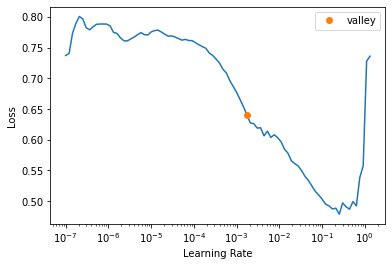

In [13]:
lr = learner.lr_find()
lr

In [14]:
learner.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.355928,0.152576,0.948134,0.925602,0.898089,0.911638,01:03


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.189275,0.123684,0.965844,0.926380,0.961783,0.943750,02:03
1,0.150824,0.078387,0.970904,0.953092,0.949045,0.951064,02:05
2,0.105946,0.067727,0.973435,0.957356,0.953291,0.955319,02:05


## Interpret results

F1-score (balanced score between Precision/Recall) is good and so are precision/recall. Note - the model was tuned using GPUs, tuning on CPUs will take significantly longer (hours).

Show a few predictions on training data.

In [15]:
learner.show_results()

,text,category,category_
0,"xxbos xxfld 1 china motorcycle xxfld 2 xxmaj this is a multi - part message in xxup mime format -- xxunk - d1b9 - 43d5 - xxunk - type : text / plain ; charset = gb2312content - transfer - encoding : quoted - printabledear xxunk fetch your name by xxunk month , our group had set up one xxup xxunk with xxmaj korean xxmaj xxunk xxmaj motors & = machinery xxunk company produces and distributes various whole motorcycle units =( xxunk ranging from xxunk to xxunk , including two - wheel motorcycle and three - wheel motorcycle , for carrying goods = and taking passengers ) and accessories especially main accessories of motorcycle , such as engine =( including xxunk , xxunk connecting rod , xxunk , engine xxunk head , xxunk body , clutch , = xxunk and xxunk rings ) , frame , fuel tank , shock",spam,spam
1,"xxbos xxfld 1 = ? xxunk = b6o = xxunk = ad = ad = a6 = b8 = a5 = f4 = a5 = b4 = a4 = a4 = b4 = e4 = aa = f8 = xxunk = b8 = xxunk xxfld 2 xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart_7hzmysbwvsemnjin8kg9ycontent - type : multipart / alternative ; \t boundary= "" xxrep 4 - = _ nextpart_7hzmysbwvsemnjin8kg9yaa "" xxrep 6 - = _ xxunk - type : text / html ; \t charset=""big5""content - transfer - encoding : xxunk xxrep 6 - = _ nextpart_7hzmysbwvsemnjin8kg9yaa xxrep 8 - = _ nextpart_7hzmysbwvsemnjin8kg9ycontent - type : application / octet - stream ; \t name= "" . / massmail-1509_files / xxunk - transfer - encoding : base64content - disposition : attachment ; \t xxunk xxrep 4 a xxunk xxrep",spam,spam
2,"xxbos xxfld 1 when to sell online seminar , lesson 2 : companies gone wrong xxfld 2 xxrep 67 * xxup if xxup you xxup are xxup reading xxup this , xxup you xxup may xxup not xxup have a xxup mime xxup version xxunk xxup mail xxup reader . xxup to xxup convert xxup your xxup subscription xxup to xxup plaintext xxup or xxup to xxup unsubscribe , xxup send xxup an xxup email xxup to xxunk xxup or visithttp : / / xxrep 3 w .fool.com / community / freemail / xxunk xxrep 67 * xxunk - foolish - xxunk - type : text / plain ; charset = us - asciicontent - disposition : inline xxrep 65 = xxup the xxup motley xxup fool xxup online xxup seminar xxup when xxup to xxup sell : xxup the xxup foolish xxup selling xxup strategy xxrep 65 = xxup",ham,spam
3,"xxbos xxfld 1 your shop web site is not being seen ! xxfld 2 xxmaj this is a multi - part message in xxup mime format . xxrep 6 - _ xxunk - type : text / plain ; charset=""iso-8859 - 1""content - transfer - encoding : xxup quoted - printable xxmaj your xxmaj shop xxmaj web xxmaj site is xxup not xxmaj being xxup xxunk ? xxup no xxup one xxup can xxup find xxup it!your web site is xxup not on many search engines and at the xxmaj bottom of their listings and as a xxunk are xxup losing customers who can not find xxunk this be changed ? xxunk xxmaj telecom xxmaj for xxup only = xxunk will submit your web site to over 350 of the worlds search xxunk full list of xxmaj search xxmaj engines at the end of this xxunk will submit your site",spam,ham
4,"xxbos xxfld 1 your membership community & commentary , 07 - 06 - 01 xxfld 2 xxrep 3 - xxunk - type : text / plain ; charset = iso-8859 - 1your xxmaj membership xxmaj community & xxmaj commentary ( july 6 , 2001)it 's xxmaj all xxmaj about xxmaj making moneyinformation to provide you with the absolute best low and no cost ways of providing traffic to your site , helping you to capitalize on the power and potential the web brings to every net - preneur . xxrep 3 - xxmaj this xxmaj issue xxmaj contains xxmaj sites xxmaj who xxmaj will xxmaj trade xxmaj links xxmaj with xxmaj you ! xxrep 3 - xxrep 13 - xxup in xxup this xxup issue xxrep 13 - xxmaj internet xxmaj success xxmaj through xxunk xxunk a xxup free xxmaj ad xxmaj in xxmaj community & xxmaj commentary xxrep 3",spam,spam
5,"xxbos xxfld 1 tribute moviemail - vol . 1 # 48 xxfld 2 xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nex

Plot confusion matrix. Note, the matrix is generated using the test data set (20% of data data).

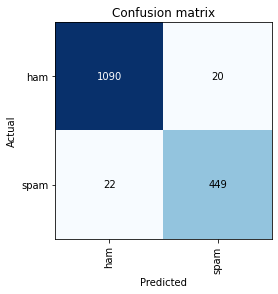

In [16]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

## Saving and loading model

In [17]:
learner.save('pretrained')

Path('models/pretrained.pth')

In [18]:
learner.load('pretrained')

# Language Model (ULMFiT approach)

Create data loader for language modeling. Set aside 10% data using **RandomSplitter** for model validation.

In [19]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df(text_cols=('from', 'subject', 'text'), 
                             is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(valid_pct=0.1, seed=12345)
    ).dataloaders(df1, bs=64)

Create data loader

In [20]:
dls_lm.show_batch(max_n = 10)

,text,text_
0,"xxbos xxfld 1 "" cnet news.com investor "" < online # xxunk > xxfld 2 news.com investor : battered stocks regain ground xxfld 3 xxup cnet xxmaj investor xxmaj dispatch xxmaj quote xxmaj lookup xxmaj enter symbol : · xxmaj symbol xxmaj lookup xxmaj quotes delayed 20 + minutes • xxmaj my xxmaj portfolio • xxmaj broker xxmaj reports • ipos • xxmaj splits • xxmaj messages & xxup xxunk 3.9 xxunk","xxfld 1 "" cnet news.com investor "" < online # xxunk > xxfld 2 news.com investor : battered stocks regain ground xxfld 3 xxup cnet xxmaj investor xxmaj dispatch xxmaj quote xxmaj lookup xxmaj enter symbol : · xxmaj symbol xxmaj lookup xxmaj quotes delayed 20 + minutes • xxmaj my xxmaj portfolio • xxmaj broker xxmaj reports • ipos • xxmaj splits • xxmaj messages & xxup xxunk 3.9 xxunk %"
1,"just 2 hours a day . xxup guaranteed http : / / xxrep 3 w xxunk / xxunk xxmaj links - xxunk xxrep 69 - xxunk is xxmaj paid e - mail xxunk xxup free xxup xxunk , _ keep _ xxunk when xxunk are added ; free advertising to xxunk , and soon chances to win xxunk : / / xxrep 3 w xxunk / xxunk / xxunk xxrep 69 -","2 hours a day . xxup guaranteed http : / / xxrep 3 w xxunk / xxunk xxmaj links - xxunk xxrep 69 - xxunk is xxmaj paid e - mail xxunk xxup free xxup xxunk , _ keep _ xxunk when xxunk are added ; free advertising to xxunk , and soon chances to win xxunk : / / xxrep 3 w xxunk / xxunk / xxunk xxrep 69 - xxup"
2,"for your xxmaj car today . xxup click xxup here for a xxup free no obligation quote.http : / / xxrep 3 w .newnamedns.com / warranty / xxmaj car troubles always seem to happen at the worst possible time . xxmaj protect yourself and your family with a quality xxmaj extended xxmaj warranty for your car , truck , or xxup suv , so that a large expense can not hit you","your xxmaj car today . xxup click xxup here for a xxup free no obligation quote.http : / / xxrep 3 w .newnamedns.com / warranty / xxmaj car troubles always seem to happen at the worst possible time . xxmaj protect yourself and your family with a quality xxmaj extended xxmaj warranty for your car , truck , or xxup suv , so that a large expense can not hit you all"
3,"xxunk maturity i sent a routine notification to his forwarding address but got no reply . xxmaj after a month we sent a reminder and finally we discovered from his contract employers the xxmaj nigerian xxmaj national xxmaj petroleum xxmaj corporation that xxmaj mr . xxmaj james xxmaj herbert died from an automobile accident . xxmaj on further investigation , i found out that he died without making a xxup will and","maturity i sent a routine notification to his forwarding address but got no reply . xxmaj after a month we sent a reminder and finally we discovered from his contract employers the xxmaj nigerian xxmaj national xxmaj petroleum xxmaj corporation that xxmaj mr . xxmaj james xxmaj herbert died from an automobile accident . xxmaj on further investigation , i found out that he died without making a xxup will and all"
4,: / / xxrep 3 w .theregister.co.uk / content / 6 / xxunk xxmaj future for online content is bright xxmaj screen xxmaj digest 's screen dump http : / / xxrep 3 w .theregister.co.uk / content / 6 / xxunk xxmaj security al - qaeda poised to strike hard via the xxmaj internet xxmaj red xxmaj alert xxmaj finger on the button http : / / xxrep 3 w .theregister.co.uk /,/ / xxrep 3 w .theregister.co.uk / content / 6 / xxunk xxmaj future for online content is bright xxmaj screen xxmaj digest 's screen dump http : / / xxrep 3 w .theregister.co.uk / content / 6 / xxunk xxmaj security al - qaeda poised to strike hard via the xxmaj internet xxmaj red xxmaj alert xxmaj finger on the button http : / / xxrep 3 w .theregister.co.uk / content
5,"tip ( lost ) ] xxrep 27 # xxmaj sub : xxmaj extracting lines x to y in a text file xxup lost # xxunk sed … xxmaj syntax : [ $ sed -n ' x , yp ' < xxunk ] . xxmaj xxunk extract lines 5 - 10 from xxunk to textout.fil … $ sed -n ' xxunk ' textout.fil xxrep 4 # xxrep 36 

Create text classifier learner. Use accuracy (higher is better), and Perplexity (lower is better: among how many words model is confused for predicting next word in sentence) for metrics.

In [21]:
lm_learner = language_model_learner(
            dls_lm, 
            AWD_LSTM, 
            wd=0.1,
            metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(valley=0.00363078061491251)

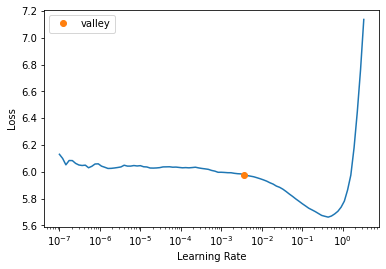

In [22]:
lr = lm_learner.lr_find()
lr

Fit one cycle - trains the new linear layer without changing the pre-trained layers (frozen).

In [23]:
lm_learner.fit_one_cycle(1, lr[0])

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.398324,4.069113,0.330520,58.505062,03:40


Save language model state.

In [24]:
lm_learner.save('1epoch')

Path('models/1epoch.pth')

Unfreeze all layers of model for futher tuning.

In [25]:
lm_learner.unfreeze()

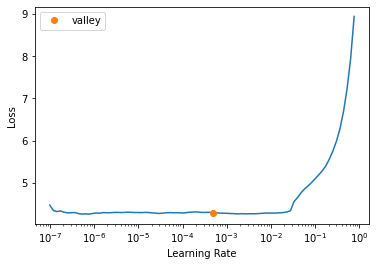

In [26]:
lr = lm_learner.lr_find()

In [28]:
lm_learner.fit_one_cycle(5, lr[0])

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.808039,3.666134,0.381968,39.100456,03:49
1,3.564882,3.339413,0.422446,28.202578,03:46
2,3.361346,3.140972,0.449303,23.126343,03:46
3,3.122689,3.049376,0.462529,21.102163,03:46
4,3.151206,3.030110,0.465379,20.699503,03:47


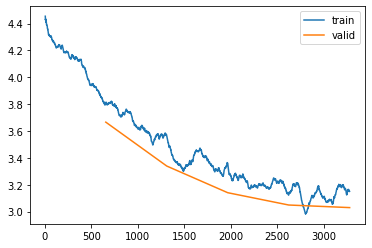

In [29]:
lm_learner.recorder.plot_loss()

Save fully tuned model.

In [30]:
lm_learner.save_encoder('finetuned')

Text generation

In [31]:
TEXT = "Free promotion"
N_WORDS = 40
N_SENTENCES = 5
preds = [lm_learner.predict(TEXT, N_WORDS, temperature=0.75)
for _ in range(N_SENTENCES)]
print("\n".join(preds))

Free promotion adult entertainment software & free adult entertainment software - online sites ( your free trial ! Make sure you suffer from the false positive rate that you 're receiving from you ) . * Remove Us …
Free promotion software offers free software and software software . This is a professional software and is designed to provide you with free access to and spread software . Use your computer to provide your own information to someone who
Free promotion fees < cdale@techmonkeys.net > xxfld 2 the best new software available on the Web for free . xxfld 3 This is a multi - part message in MIME format . ------ ====== ______ nextpartnextpartnextpartnextpartnextpartnextpart ______
Free promotion calls xxfld 3 Instant Access Access ! Live Internet Music Show ! And That 's How To Generate Internet Revenue Software ! Find out
Free promotion calls today ! xxfld 3 Act now ! ! You are receiving this mail because you subscribed to iton use Perl . To stop receiving this and othermessages 

Create DataLoaders for classification.

In [32]:
dls_cls = DataBlock(
            blocks=(TextBlock.from_df(text_cols=('from', 'subject', 'text'), 
                              is_lm=False, 
                              vocab=dls_lm.vocab), 
            CategoryBlock),
            get_x=ColReader('text'),
            get_y=ColReader('category'), 
            splitter=RandomSplitter(valid_pct=0.2, seed=12345)
            ).dataloaders(df1, bs=64)

In [33]:
dls_cls.show_batch(max_n=3)

,text,category
0,"xxbos xxfld 1 "" = ? iso-2022 - xxunk "" < hito@opentext.com > xxfld 2 = ? iso-2022 - xxunk xxfld 3 xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ xxrep 3 0 2_01c228ca.593b5280content - type : text / plain ; \t xxunk - xxunk - transfer - encoding : xxunk < xxunk xxrep 3 $ xxunk ! # xxunk ! # xxunk % / % xxunk , xxunk ! $ xxunk % / $ xxunk xxrep 3 $ xxunk , xxunk ! # xxunk : xxunk $ xxunk # ! xxunk xxrep 3 $ xxup xxunk / $ @$5$$ ! # ! xxunk / ! xxunk > xxunk $ / $ * 4j xxrep 5 $ ? $ 7$^$9 ! # xxunk xxrep 38 - + xxunk \ xxunk # % "" xxunk",ham
1,"xxbos xxfld 1 "" mr . fork "" < fork_list@hotmail.com > xxfld 2 re : sed / s / united states / roman empire / g xxfld 3 "" free trade and free markets have proven their ability to lift xxunk out of xxunk not a socio - political / history buff - does anybody have some xxunk ? xxrep 5 - xxmaj original xxmaj message xxrep 5 - xxmaj from : "" rohit xxmaj khare "" xxmaj to : xxmaj sent : xxmaj friday , xxmaj september 20 , 2002 xxunk pmsubject : sed / s / xxmaj united xxmaj states / xxmaj roman xxmaj empire / g > > a world where some live in comfort and plenty , while half of the human > > race lives on less than $ 2 a day , is neither just nor stable . > > xxmaj absolutely correct .",ham
2,"xxbos xxfld 1 rohit khare < khare@alumni.caltech.edu > xxfld 2 sed / s / united states / roman empire / g xxfld 3 > a world where some live in comfort and plenty , while half of the human > race lives on less than $ 2 a day , is neither just nor xxunk correct . xxmaj perhaps the most fundamental thing to realize about life on xxmaj earth xxunk following is a fascinating document of official xxmaj government policy that bears close reading . xxmaj it is the aspirations of a wonderful nation in an imperfect world . > xxmaj the war on terrorism is not a clash of civilizations . xxmaj it does , > however , reveal the clash inside a civilization , a battle for the > future of the xxmaj muslim world . xxmaj this is a struggle of ideas and this is an",ham


Create text classification learner.

In [39]:
learn = text_classifier_learner(dls_cls, 
                                AWD_LSTM, 
                                drop_mult=0.5, 
                                metrics=[accuracy, Precision(), Recall(), F1Score()])

In [40]:
learn = learn.load_encoder('finetuned')

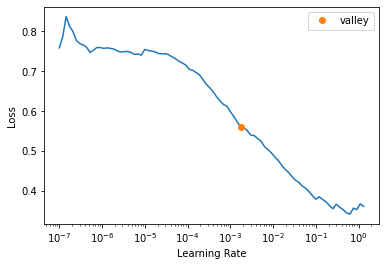

In [41]:
lr = learn.lr_find()

In [42]:
learn.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.181360,0.075550,0.981013,0.953815,0.985477,0.969388,01:07


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.078981,0.072088,0.980380,0.953722,0.983402,0.968335,02:08
1,0.062020,0.049131,0.982278,0.963265,0.979253,0.971193,02:09
2,0.045046,0.032933,0.985443,0.973196,0.979253,0.976215,02:08


Plot confusion matrix.

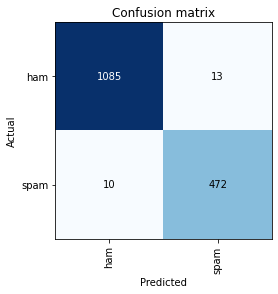

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()